# More features

In [3]:
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

from oemof.solph import (Sink, Source, Transformer, Bus, Flow, Model,
                         EnergySystem, Investment, NonConvex)
import oemof.outputlib as outputlib
import oemof.solph as solph
import oemof.graph as graph
from oemof.tools import economics

import pyomo.environ as po

solver = 'cbc'

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [8.0, 6.0]

In [4]:
color_dict ={
             'coal': '#755d5d',
             'gas': '#c76c56',
             'oil': '#494a19',
             'lignite': '#56201d',
             'wind': '#4ca7c3',
             'pv': '#ffde32',
             'excess_el': '#9a9da1',
             'pp_coal': '#755d5d',
             'pp_gas': '#c76c56',
             'pp_chp': '#eeac7e',
             'b_heat_source': '#cd3333',
             'heat_source': '#cd3333',
             'heat_pump': '#42c77a',
             'electricity': '#0079ff',
             'demand_el': '#0079ff',
             'shortage_el': '#ff2626',
             'excess_el': '#ff2626',
             'biomass': '#01b42e',
             'pp_biomass': '#01b42e'}

In [5]:
def draw_graph(energysystem, edge_labels=True, node_color='#eeac7e',
               edge_color='#eeac7e', plot=True, node_size=5500,
               with_labels=True, arrows=True, layout='dot'):
    
    grph = graph.create_nx_graph(energysystem)
    
    if type(node_color) is dict:
        node_color = [node_color.get(g, '#AFAFAF') for g in grph.nodes()]

    # set drawing options
    options = {
     'prog': 'dot',
     'with_labels': with_labels,
     'node_color': node_color,
     'edge_color': edge_color,
     'node_size': node_size,
     'arrows': arrows,
     'font_size': 12,
     'font_color': 'w'
    }

    # draw graph
    pos = nx.drawing.nx_agraph.graphviz_layout(grph, prog=layout)

    nx.draw(grph, pos=pos, **options)

    # add edge labels for all edges
    if edge_labels is True and plt:
        labels = nx.get_edge_attributes(grph, 'weight')
        nx.draw_networkx_edge_labels(grph, pos=pos, edge_labels=labels)

    # show output
    if plot is True:
        plt.show()

def initialize_basic_energysystem():
    # initialize and provide data
    datetimeindex = pd.date_range('1/1/2016', periods=240, freq='H')
    filename = 'input_data.csv'
    data = pd.read_csv(filename, sep=',')
    energysystem = EnergySystem(timeindex=datetimeindex)

    # buses
    bcoal = Bus(label='coal', balanced=False)
    bgas = Bus(label='gas', balanced=False)
    bel = Bus(label='electricity')
    energysystem.add(bcoal, bgas, bel)

    # sources
    energysystem.add(Source(label='wind', outputs={bel: Flow(
        actual_value=data['wind'], nominal_value=66.3, fixed=True)}))

    energysystem.add(Source(label='pv', outputs={bel: Flow(
        actual_value=data['pv'], nominal_value=65.3, fixed=True)}))

    # excess and shortage to avoid infeasibilies
    energysystem.add(Sink(label='excess_el', inputs={bel: Flow()}))
    energysystem.add(Source(label='shortage_el',
                         outputs={bel: Flow(variable_costs=100000)}))

    # demands (electricity/heat)
    energysystem.add(Sink(label='demand_el', inputs={bel: Flow(
        nominal_value=85, actual_value=data['demand_el'], fixed=True)}))
    
    return bcoal, bgas, bel, energysystem


def postprocess_and_plot(optimization_model):
    results = outputlib.processing.results(optimization_model)

    results_el = outputlib.views.node(results, 'electricity')

    el_sequences = results_el['sequences']

    to_el = {key[0][0]: key for key in el_sequences.keys() if key[0][1] == 'electricity' and key[1] == 'flow'}
    to_el = [to_el.pop('pv'), to_el.pop('wind')] + list(to_el.values())
    el_prod = el_sequences[to_el]

    fig, ax = plt.subplots(figsize=(14, 6))
    for key in el_sequences.keys():
        color_dict[key] = color_dict[key[0][0]]
    c=[color_dict.get(x, '#333333') for x in el_prod.columns]
    el_prod.plot.area(ax=ax, color=c)
    el_sequences[(('electricity', 'demand_el'), 'flow')].plot(ax=ax, linewidth=3, c='k')
    legend = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # legend outside of plot

# Begin by adding two powerplants

In [6]:
bcoal, bgas, bel, energysystem = initialize_basic_energysystem()

In [7]:
# power plants
energysystem.add(Transformer(
    label='pp_coal',
    inputs={bcoal: Flow()},
    outputs={bel: Flow(nominal_value=20.2, variable_costs=25)},
    conversion_factors={bel: 0.39}))

energysystem.add(Transformer(
    label='pp_gas',
    inputs={bgas: Flow()},
    outputs={bel: Flow(nominal_value=41, variable_costs=40)},
    conversion_factors={bel: 0.50}))

/home/jann/Desktop/repos/workshop/env/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/jann/Desktop/repos/workshop/env/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


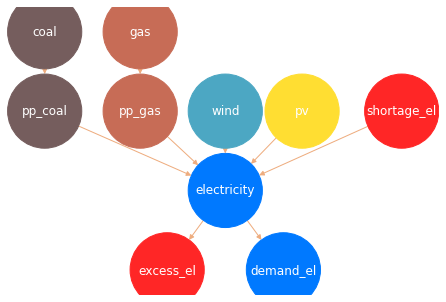

In [8]:
draw_graph(energysystem, node_color=color_dict)

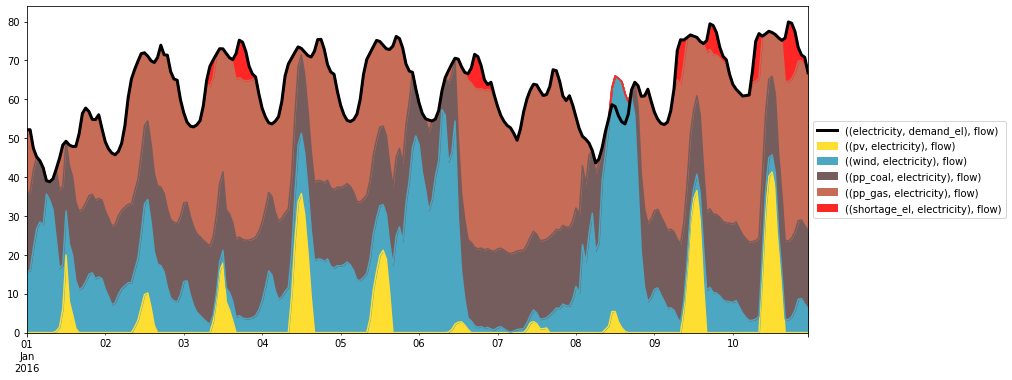

In [9]:
# create optimization model based on energy_system
optimization_model = Model(energysystem=energysystem)

# solve problem
optimization_model.solve(solver=solver,
                         solve_kwargs={'tee': False, 'keepfiles': False})

postprocess_and_plot(optimization_model)

# Investment

In [10]:
bcoal, bgas, bel, energysystem = initialize_basic_energysystem()

In [11]:
# power plants
energysystem.add(Transformer(
    label='pp_coal',
    inputs={bcoal: Flow()},
    outputs={bel: Flow(nominal_value=20.2, variable_costs=25)},
    conversion_factors={bel: 0.39}))

energysystem.add(Transformer(
    label='pp_gas',
    inputs={bgas: Flow()},
    outputs={bel: Flow(nominal_value=41, variable_costs=40)},
    conversion_factors={bel: 0.50}))

epc = economics.annuity(capex=10000, n=20, wacc=0.05)

bbio = Bus(label='biomass', balanced=False)
energysystem.add(bbio)

energysystem.add(Transformer(
    label='pp_biomass',
    inputs={bbio: Flow()},
    outputs={bel: Flow(investment=Investment(ep_costs=epc,
                                             maximum=15,
                                             existing=2),
                       variable_costs=25)},
    conversion_factors={bel: 0.39}))

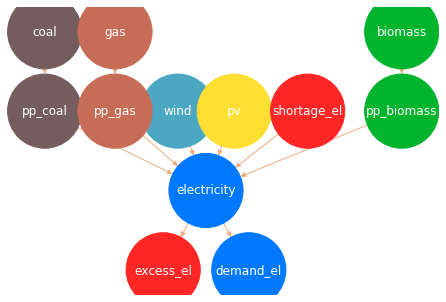

In [12]:
draw_graph(energysystem, node_color=color_dict)

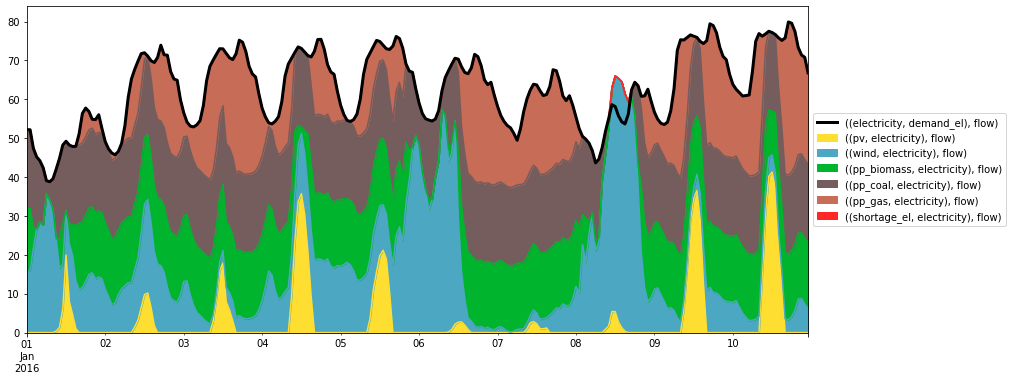

In [13]:
# create optimization model based on energy_system
optimization_model = Model(energysystem=energysystem)

# solve problem
optimization_model.solve(solver=solver,
                         solve_kwargs={'tee': False, 'keepfiles': False})

postprocess_and_plot(optimization_model)